In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import copy
import cv2
import keras
from string import printable
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, Sequential
from keras.datasets import fashion_mnist
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from PIL import Image
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import RMSprop
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras.callbacks import TensorBoard
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


# 1 Autoencoder

In [59]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 28, 28, 1))
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print (x_train.shape)

(60000, 28, 28, 1)


In [41]:
img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoding = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoding)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoding = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(img, decoding)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 4, 4, 8)           0         
__________

In [54]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 285s 5ms/step - loss: 0.3111 - val_loss: 0.3274
Epoch 2/20
60000/60000 [==============================] - 287s 5ms/step - loss: 0.2918 - val_loss: 0.2992
Epoch 3/20
60000/60000 [==============================] - 287s 5ms/step - loss: 0.2863 - val_loss: 0.2947
Epoch 4/20
60000/60000 [==============================] - 285s 5ms/step - loss: 0.2830 - val_loss: 0.2876
Epoch 5/20
60000/60000 [==============================] - 285s 5ms/step - loss: 0.2807 - val_loss: 0.2797
Epoch 6/20
60000/60000 [==============================] - 285s 5ms/step - loss: 0.2788 - val_loss: 0.2794
Epoch 7/20
60000/60000 [==============================] - 285s 5ms/step - loss: 0.2774 - val_loss: 0.2784
Epoch 8/20
60000/60000 [==============================] - 285s 5ms/step - loss: 0.2763 - val_loss: 0.2783
Epoch 9/20
60000/60000 [==============================] - 285s 5ms/step - loss: 0.2754 - val_loss: 0.2

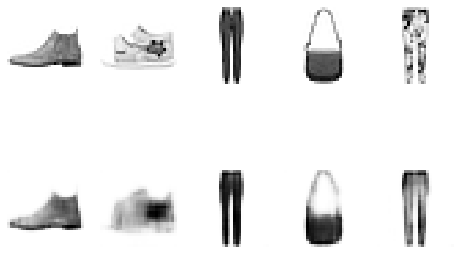

In [56]:
decoded_img = autoencoder.predict(x_test)
plt.figure()
for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(x_test[-i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, 5, i+6)
    plt.imshow(decoded_img[-i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2.1 Deep CNN

In [14]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28,1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28,1).astype('float32') / 255
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

model = Sequential()
model.add(Conv2D(filters = 32,kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 64,kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
__________

In [16]:
model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 73s 1ms/step - loss: 0.2854 - acc: 0.8944 - val_loss: 0.2576 - val_acc: 0.9037
Epoch 2/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.2802 - acc: 0.8975 - val_loss: 0.2576 - val_acc: 0.9033
Epoch 3/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.2718 - acc: 0.8999 - val_loss: 0.2517 - val_acc: 0.9039
Epoch 4/20
60000/60000 [==============================] - 73s 1ms/step - loss: 0.2673 - acc: 0.9014 - val_loss: 0.2495 - val_acc: 0.9076
Epoch 5/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.2591 - acc: 0.9036 - val_loss: 0.2466 - val_acc: 0.9084
Epoch 6/20
60000/60000 [==============================] - 73s 1ms/step - loss: 0.2581 - acc: 0.9034 - val_loss: 0.2417 - val_acc: 0.9113
Epoch 7/20
60000/60000 [==============================] - 72s 1ms/step - loss: 0.2575 - acc: 0.9050 - val_loss: 0.2396 - val_acc

In [17]:
print("Train classification accuracy rate %0.05f" % model.evaluate(X_train, Y_train)[1])
print("Test classification accuracy rate %0.05f" % model.evaluate(X_test, Y_test)[1])

60000/60000 [==============================] - 23s 383us/step
Train classification accuracy rate 0.94877
10000/10000 [==============================] - 4s 385us/step
Test classification accuracy rate 0.91640


# 2.2 Transfer Learning

In [6]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_train = [cv2.cvtColor(cv2.resize(i, (48,48)), cv2.COLOR_GRAY2BGR) for i in X_train]
X_test = [cv2.cvtColor(cv2.resize(i, (48,48)), cv2.COLOR_GRAY2BGR) for i in X_test]
X_train = np.concatenate([arr[np.newaxis] for arr in X_train])
X_test = np.concatenate([arr[np.newaxis] for arr in X_test])
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

4423680/4422102 [==============================] - 1s 0us/step


In [7]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(48,48,3))
conv_base.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

58892288/58889256 [==============================] - 4s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1779s 30ms/step - loss: 0.6111 - acc: 0.8054 - val_loss: 0.5533 - val_acc: 0.8112
Epoch 2/10
60000/60000 [==============================] - 1774s 30ms/step - loss: 0.5062 - acc: 0.8273 - val_loss: 0.4971 - val_acc: 0.8278
Epoch 3/10
60000/60000 [==============================] - 1776s 30ms/step - loss: 0.4634 - acc: 0.8402 - val_loss: 0.4680 - val_acc: 0.8359
Epoch 4/10
60000/60000 [==============================] - 1776s 30ms/step - loss: 0.4381 - acc: 0.8464 - val_loss: 0.4488 - val_acc: 0.8401
Epoch 5/10
60000/60000 [==============================] - 1779s 30ms/step - loss: 0.4208 - acc: 0.8515 - val_loss: 0.4344 - val_acc: 0.8472
Epoch 6/10
60000/60000 [==============================] - 1776s 30ms/step - loss: 0.4075 - acc: 0.8555 - val_loss: 0.4259 - val_acc: 0.8506
Epoch 7/10
60000/60000 [==============================] - 1777s 30ms/step - loss: 0.3976 - acc: 0.8588 - val_l

In [8]:
print("Train classification accuracy rate %0.05f" % model.evaluate(X_train, y_train)[1])
print("Test classification accuracy rate %0.05f" % model.evaluate(X_test, y_test)[1])

60000/60000 [==============================] - 1531s 26ms/step
Train classification accuracy rate 0.13635
10000/10000 [==============================] - 259s 26ms/step
Test classification accuracy rate 0.13940
